In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

## **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/drive/MyDrive/datasets/archive/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 98, 'yes': 155}

So we have 155 Brain MRI images with a tumor and 98 healthey ones.

Text(0.5, 1.0, 'no')

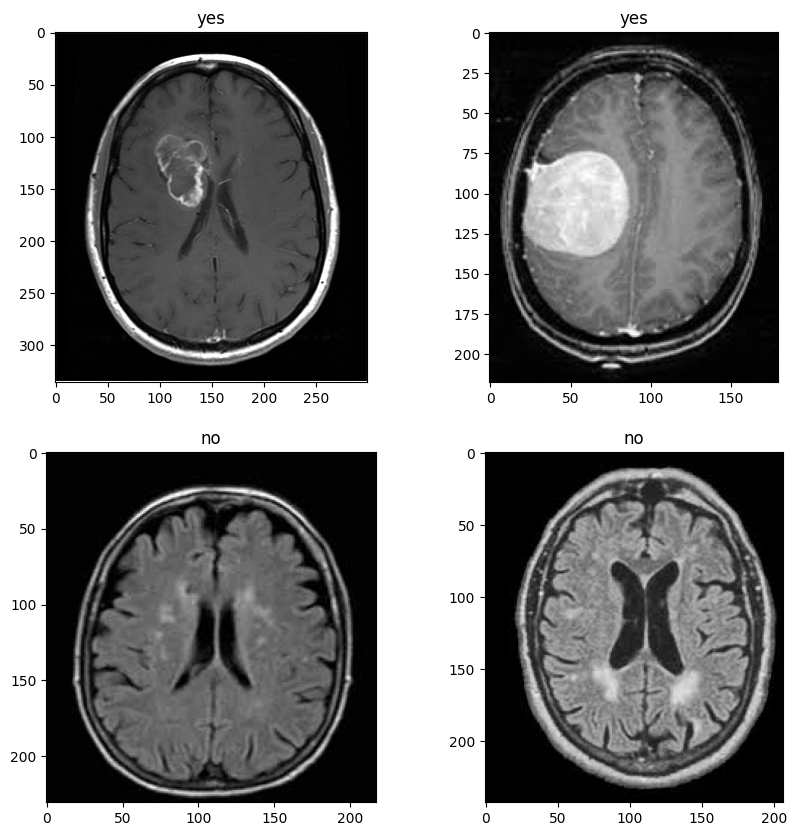

In [ ]:
#Plot some MRI images
yes = '/content/drive/MyDrive/datasets/archive/yes'
no = '/content/drive/MyDrive/datasets/archive/no'
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join(yes, os.listdir(yes)[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join(yes, os.listdir(yes)[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join(no, os.listdir(no)[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join(no, os.listdir(no)[1])))
plt.title('no')

## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [ ]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [ ]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


In [ ]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='/content/drive/MyDrive/datasets/archive/brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='/content/drive/MyDrive/datasets/archive/brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='./aug_data/no')

## **Split data into train, validation and test sets**

In [ ]:
#Count images in the two folders: yes (Tumor) and no (Healthy) in the folder of augmented images
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 1275, 'yes': 1396}

In [ ]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [ ]:
#Create the training set
create_folders('train', 0.7)

train Already exists


In [ ]:
#Create the test set
create_folders('test', 0.15)

test Already exists


In [ ]:
#Create the validation set
create_folders('val', 0.15)

val Already exists


In [ ]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthy)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [ ]:
#Count images in the training set
count_img('train')

{'no': 890, 'yes': 976}

In [ ]:
#Count images in the test set
count_img('test')

{'no': 190, 'yes': 209}

In [ ]:
#Count images in the validation set
count_img('val')

{'no': 190, 'yes': 209}

## **Image Preprocessing**

In [ ]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):

    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

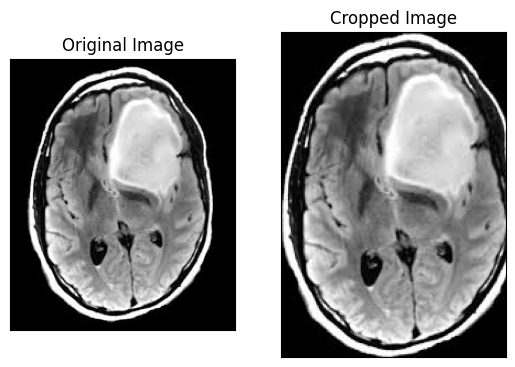

In [ ]:
#Example
ex_img = cv2.imread('/content/drive/MyDrive/datasets/archive/brain_tumor_dataset/yes/Y105.jpg')
img = crop_brain_contour(ex_img, plot=True)

In [ ]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1866
X shape is: (1866, 240, 240, 3)
y shape is: (1866, 1)


In [ ]:
#Define a function that plot images
def plot_sample_images(X, y, n=10):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
#Plot samples from the training set
#plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [ ]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


In [ ]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


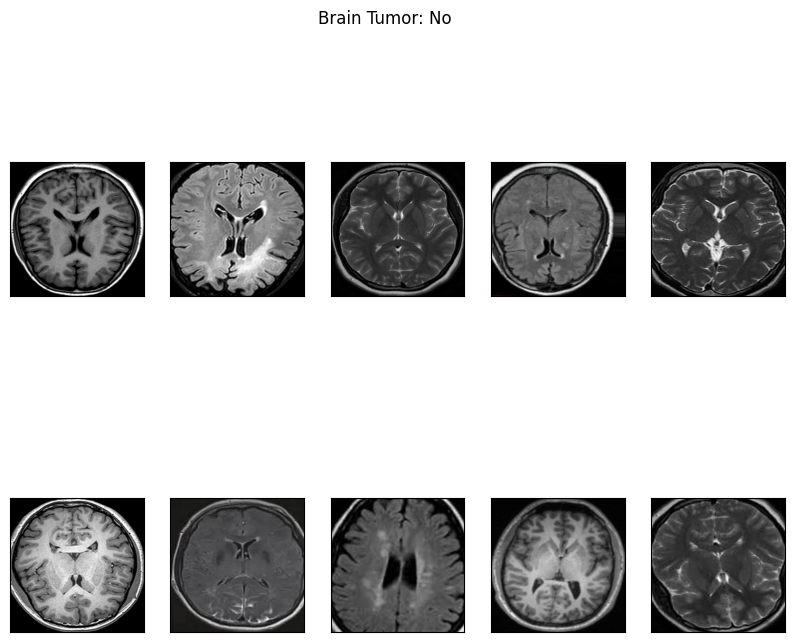

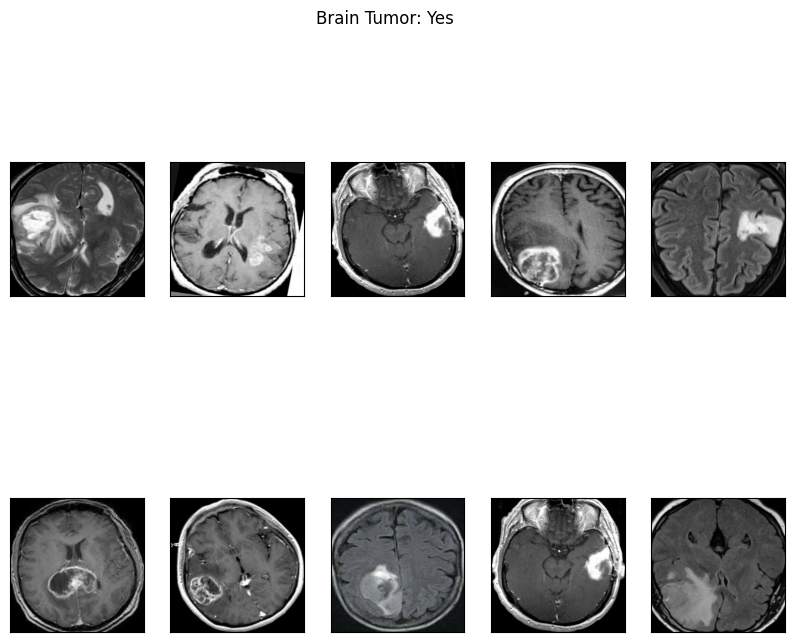

In [ ]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [ ]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

In [ ]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [ ]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 10, epochs = 5, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/5
187/187 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.6635
Epoch 1: val_accuracy improved from -inf to 0.78446, saving model to ./bestmodel.h5
187/187 [==============================] - 20s 60ms/step - loss: 0.6038 - accuracy: 0.6635 - val_loss: 0.4724 - val_accuracy: 0.7845
Epoch 2/5
187/187 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7894
Epoch 2: val_accuracy improved from 0.78446 to 0.80952, saving model to ./bestmodel.h5
187/187 [==============================] - 8s 43ms/step - loss: 0.4579 - accuracy: 0.7894 - val_loss: 0.4259 - val_accuracy: 0.8095
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8676
Epoch 3: val_accuracy improved from 0.80952 to 0.88221, saving model to ./bestmodel.h5
187/187 [==============================] - 8s 43ms/step - loss: 0.3213 - accuracy: 0.8676 - val_loss: 0.3326 - val_accuracy: 0.8822
Epoch 4/5
186/187 [============================>.] - ETA: 0s

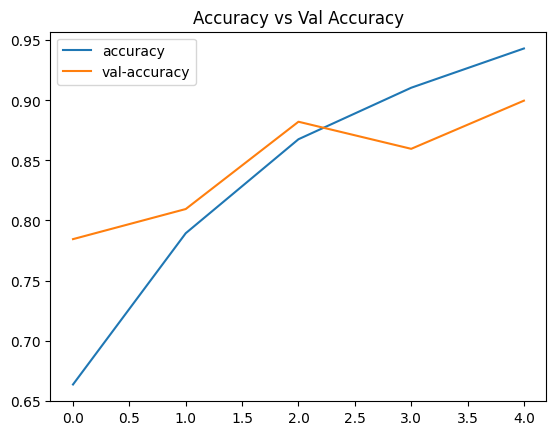

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

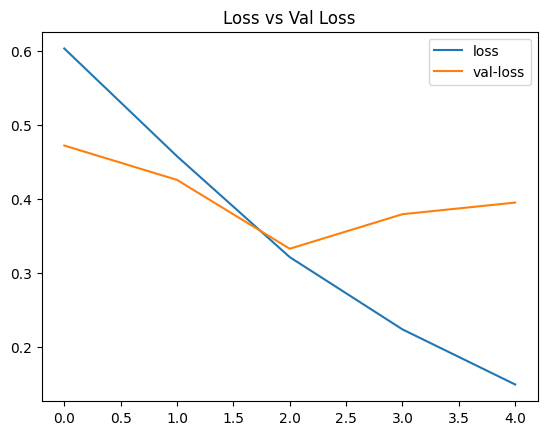

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 2s 67ms/step - loss: 0.2900 - accuracy: 0.8772
The accuracy of our model is 0.8771929740905762


## **SGD Optimizer**

In [ ]:
#Compile our model
model.compile(optimizer = 'sgd', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [ ]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 10, epochs = 5, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD

# Load the data.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Define the input shape and number of classes.
input_shape = (28, 28, 1)
num_classes = 10

# Normalize the pixel values.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define the model.
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Define the optimizer.
sgd = SGD(lr=0.01)

# Compile the model.
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])



11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.3,verbose=1)

# Evaluate the model.
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/50
329/329 [==============================] - 2s 5ms/step - loss: 0.2938 - accuracy: 0.9156 - val_loss: 0.3022 - val_accuracy: 0.9114
Epoch 2/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2885 - accuracy: 0.9169 - val_loss: 0.3096 - val_accuracy: 0.9069
Epoch 3/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2839 - accuracy: 0.9174 - val_loss: 0.2856 - val_accuracy: 0.9186
Epoch 4/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2793 - accuracy: 0.9195 - val_loss: 0.2840 - val_accuracy: 0.9176
Epoch 5/50
329/329 [==============================] - 1s 5ms/step - loss: 0.2754 - accuracy: 0.9207 - val_loss: 0.2799 - val_accuracy: 0.9189
Epoch 6/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2709 - accuracy: 0.9214 - val_loss: 0.2821 - val_accuracy: 0.9177
Epoch 7/50
329/329 [==============================] - 2s 5ms/step - loss: 0.2670 - accuracy: 0.9232 - val_loss: 0.2884 - val_accuracy: 0.9153
Epoch 

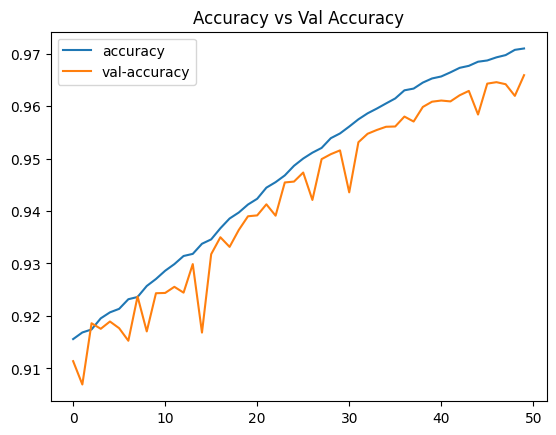

In [ ]:
#Plot the graphical interpretation
h = history.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

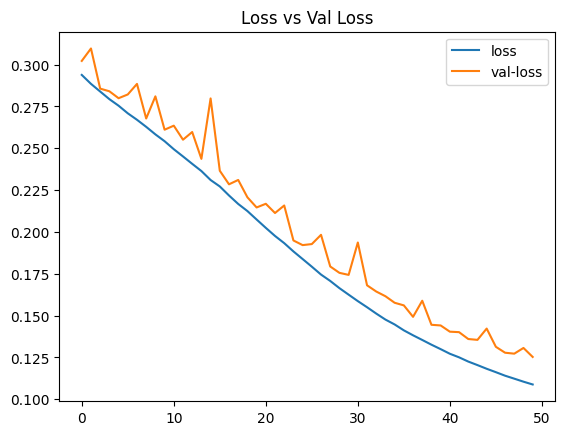

In [ ]:
#Plot the graphical interpretation
h = history.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()